In [319]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def relu2(x):
    return tf.where(x <= 0, 0, x**2)

def softplus(x):
    return tf.math.log(1 + tf.exp(x))

def smooth_relu2(x):
    return x * softplus(x)

def x_sol(t):
    return (t**3)/6

x_test1 = 1/6
x_test0 = 0

def sqrt_sol(t):
    return (4/15)*t**(5/2)

sqrt_test1 = 4/15
sqrt_test0 = 0

def sin_true_y(t):
    return -1* np.sin(t)

sin_test1 = -0.8414709848
sin_test0 = 0


class ODENet_WiderShallow(tf.keras.Model):
    def __init__(self, layer1params = 32, regularization_rate=0.01):  # Increased layer1params
        super(ODENet_WiderShallow, self).__init__()
        
        regularizer = tf.keras.regularizers.l2(regularization_rate)
        
        self.dense1 = tf.keras.layers.Dense(layer1params, activation=smooth_relu2, kernel_regularizer=regularizer)
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.dense2 = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.dense1(x)
        x = self.bn1(x)  # Apply batch normalization
        return self.dense2(x)

# class ODENet_Shallow(tf.keras.Model):
#     def __init__(self, layer1params = 100):
#         super(ODENet_Shallow, self).__init__()
#         self.dense1 = tf.keras.layers.Dense(1, activation=smooth_relu2)

#     def call(self, x):
#         return self.dense1(x)
# class ODENet_Shallow(tf.keras.Model):
#     def __init__(self, layer1params = 100):
#         super(ODENet_Shallow, self).__init__()
#         layer1_parameters = layer1params
#         self.bn1 = tf.keras.layers.BatchNormalization()
#         self.dense1 = tf.keras.layers.Dense(layer1_parameters, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
#         self.dense2 = tf.keras.layers.Dense(1)

#     def call(self, x):
#         x = self.bn1(x)  # Use batch normalization before dense layer
#         x = relu2(self.dense1(x))
#         return self.dense2(x)

    
class ODENet_Deep(tf.keras.Model):
    def __init__(self, layer1params = 100, layer2params = 100):
        super(ODENet_Deep, self).__init__()
        layer1_parameters = layer1params
        layer2_parameters = layer2params
        self.dense1 = tf.keras.layers.Dense(layer1_parameters, activation=relu3)
        self.dense2 = tf.keras.layers.Dense(layer2_parameters, activation=relu3)
        self.dense3 = tf.keras.layers.Dense(1)
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)
    
model = ODENet_WiderShallow()

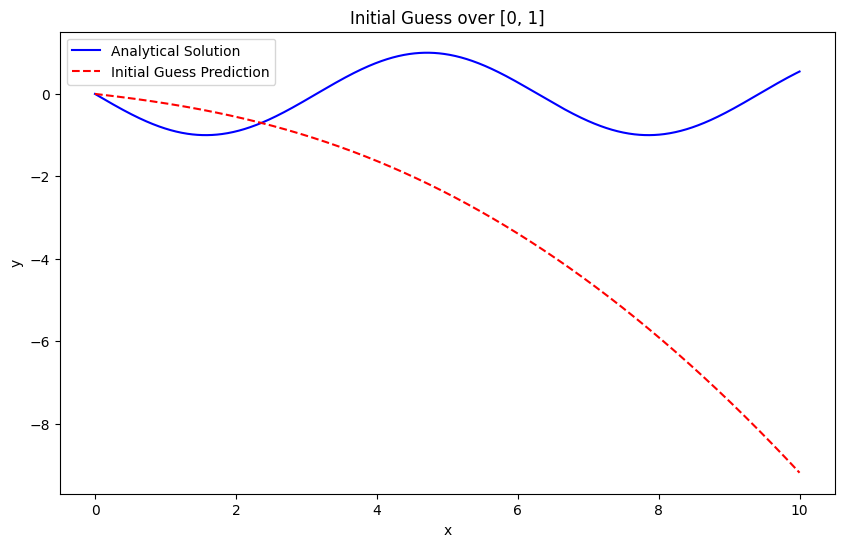

In [320]:
#initial guess

test_n = 1000
x_test = np.linspace(0, 10, test_n).reshape(-1, 1)
y_true = sin_true_y(x_test)
y_pred = model(x_test)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_true, label='Analytical Solution', color='blue')
plt.plot(x_test, y_pred, label='Initial Guess Prediction', color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Initial Guess over [0, 1]')
plt.show()

In [321]:
# differential equation 
# y'' = x, y(0) = 0, y(1) = 0

def f(x):
    return x

# differential equation 
# y'' = sinx, y(0) = 0, y(1) = 0

def sin(x):
    return np.sin(x)

# differential equation 
# y'' = sqrtx, y(0) = 0, y(1) = 0

def sqrt(x):
    return np.sqrt(x)


def atom(model,x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = model(x)
        y2 = relu2(x)
        plt.plot(x, y, label='Relu2 Prediction', color='blue', linestyle='--')
        plt.plot(x, y2, label='Relu2 Prediction', color='green', linestyle='--')
        dy_dx = tape.gradient(y, x)
        dy_dx2 = tape.gradient(y2, x)
        plt.plot(x, dy_dx, label='Relu2 Prediction', color='blue', linestyle='--')
        plt.plot(x, dy_dx2, label='Relu2 Prediction', color='green', linestyle='--')


def loss_fn(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = model(x)
        dy_dx = tape.gradient(y, x)
        d2y_dx2 = tape.gradient(dy_dx, x)
    residual = d2y_dx2 - sin(x)
    
    # Calculate the loss as the squared error
    loss = tf.reduce_mean(tf.square(residual))
    
    # Add boundary conditions to the loss
    boundary_weight = 1.0
    loss += boundary_weight * 0.5 * tf.square(model(tf.constant([[0.0]], dtype=tf.float32))) # for y(0) = 0
    loss += boundary_weight * 0.5 * tf.square(model(tf.constant([[1.0]], dtype=tf.float32)) + tf.constant(0.8414709848, dtype=tf.float32)) # for y(1) = 1/6
    
    return loss



In [322]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, clipnorm=1.0)



#create a gradient model for the fucntion not just the gradient
def train_step(model, x):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, x)
    grads = tape.gradient(loss, model.trainable_weights)
    if any([tf.math.reduce_any(tf.math.is_nan(g)) for g in grads]):
        print("NaN gradients detected!")
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

In [323]:
for weight in model.weights:
    if tf.math.reduce_any(tf.math.is_nan(weight)):
        print("NaNs found in model weights!")

num_training_points = 1000
x_samples = tf.reshape(tf.linspace(0.0, 10.0, num_training_points), (-1, 1))
epochs = 1000
for step in range(epochs):
    loss = train_step(model, x_samples)
    if step % 100 == 0:
        print(f"Step: {step}, Loss: {loss.numpy()}")
    if step == 999:
       print(f"Final Loss: {loss.numpy()}") 

Step: 0, Loss: [[0.7384031]]
Step: 100, Loss: [[0.3876103]]
Step: 200, Loss: [[0.38265556]]
Step: 300, Loss: [[0.35924935]]
Step: 400, Loss: [[0.27746126]]
Step: 500, Loss: [[0.15532002]]
Step: 600, Loss: [[0.11739558]]
Step: 700, Loss: [[0.09360804]]
Step: 800, Loss: [[0.08342524]]
Step: 900, Loss: [[0.07609735]]
Final Loss: [[0.06391431]]


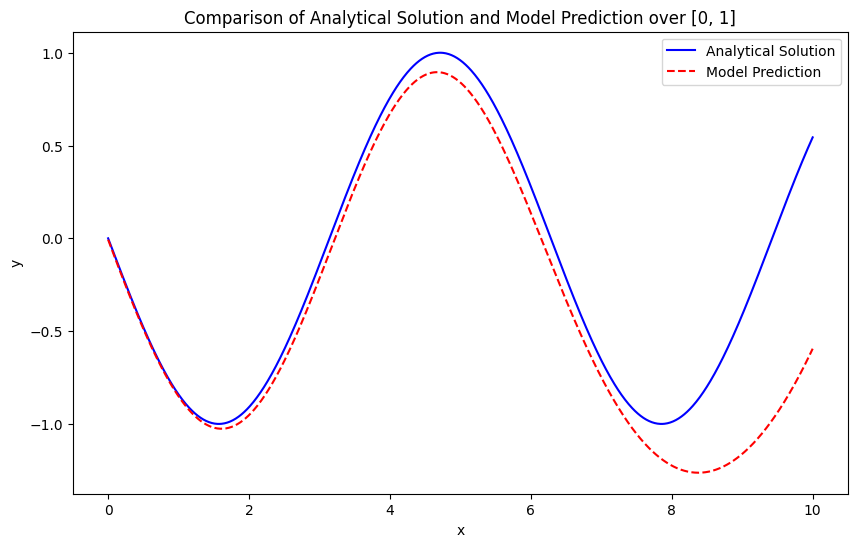

In [324]:
test_n = 1000
x_test = np.linspace(0, 10, test_n).reshape(-1, 1)
y_true = sin_true_y(x_test)
y_pred = model(x_test)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_true, label='Analytical Solution', color='blue')
plt.plot(x_test, y_pred, label='Model Prediction', color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison of Analytical Solution and Model Prediction over [0, 1]')
plt.show()

In [325]:
max_error_array = np.absolute(y_true - y_pred)
max_error = np.max(max_error_array)
max_error

1.1387299